###### *Created by James A. Scharf*
###### *Last edited: 6/25/19*

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

stop_words = set(stopwords.words("english"))

In [28]:
stop_words.update(["production", "equipment", "event", "estimate", "for", "&", "other", "from", "opposing", "time", "other", "'", "'estimate'"])

In [29]:
import string

def preprocess(phrase):
    phrase = phrase.lower()
    phrase = phrase.translate(str.maketrans('', '', string.punctuation))
    phrase = word_tokenize(phrase)
    #punct = "`~!@#$%^&*()_+=|\}]{[':;?/>.<,-"
    nums = "1234567890"
    phrase = [w for w in phrase if not w in stop_words]
    #phrase = [w for w in phrase if not w in punct]
    phrase = [w for w in phrase if not w in nums]
    #phrase = [stemmer.stem(w) for w in phrase]
    #tb = TextBlob(" ".join(phrase))
    #phrase = tb.correct().split()

    return " ".join(phrase)

In [30]:
df = pd.read_csv('../rawdata/purposecodes.csv', engine="python")

# MiniBatch K Means (Centroid)

MiniBatch K Means is a fast version of the *K Means* clustering algorithm. The general idea is that you have a predetermined value, K which is the number of clusters you have. You randomly select *K* points in the dataset and try to find the centers, or "centroids," of each grouping.

In [31]:
df_kmeans = df.copy().drop_duplicates(subset="pur", keep="first")

In [32]:
corpus = df_kmeans["pur"].astype(str)

vectorizer = TfidfVectorizer()

corpus = [preprocess(phrase) for phrase in corpus]
X = vectorizer.fit_transform(corpus)

## Finding the Optimal number of categories

To find the optimal number of categories, we implement something called the *elbow method*. The chink in the inertia curve where it begins to flatten out is the best number of categories for our dataset. More information, and inspiration for the next code block, is available [here](https://pythonprogramminglanguage.com/kmeans-elbow-method/).

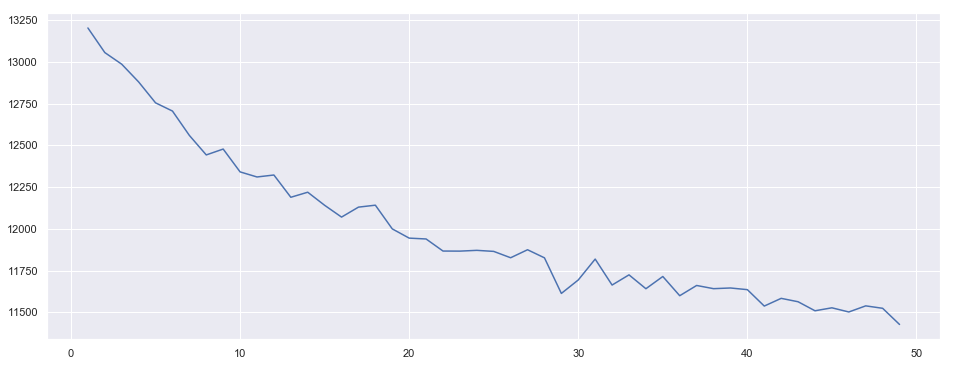

In [33]:
from sklearn.cluster import MiniBatchKMeans

inertias = []
for numK in range(1, 50):
    kmeans = MiniBatchKMeans(n_clusters=numK).fit(X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(16, 6))
sns.lineplot(range(1,50), inertias)

Depending on how you interpret the graph above, the optimal number of categories could be 8, 13, 20 or 28. In my opinion, 28 is the likely the number of true categories. This seems to indicate that our original eight categories are agglomerations of several sub-categories that are truly distinct, therefore suggesting that our flat labeling could be altered to reflect a hierarchy. We would do this by picking a high number of sub-categories (perhaps even larger than 20), and then studying each of the resulting clusters to merge some together.

In my study of results below, I utilize a K of 8 flat categories without merging them together.

In [34]:
k = 13
kmeans = MiniBatchKMeans(n_clusters=k).fit(X)

In [35]:
kmeans_centroids = kmeans.cluster_centers_
kmeans_labels = kmeans.labels_
df_kmeans["cluster"] = kmeans_labels
df_kmeansKey = df_kmeans[["pur", "cluster"]]
#now convert this into a key for later merging
kmeansDict = df_kmeansKey.to_dict()

In [36]:
df_kmeansKey.to_csv("kmeans.csv")

# Visualizing Coherence of clusters
We reduce dimensionality of purpose code vectors (mathematical representations of a purpose code) using a PCA to visualize in 2 dimensions. We can see that there is a degree of polution between each category, but they are relatively delineated.

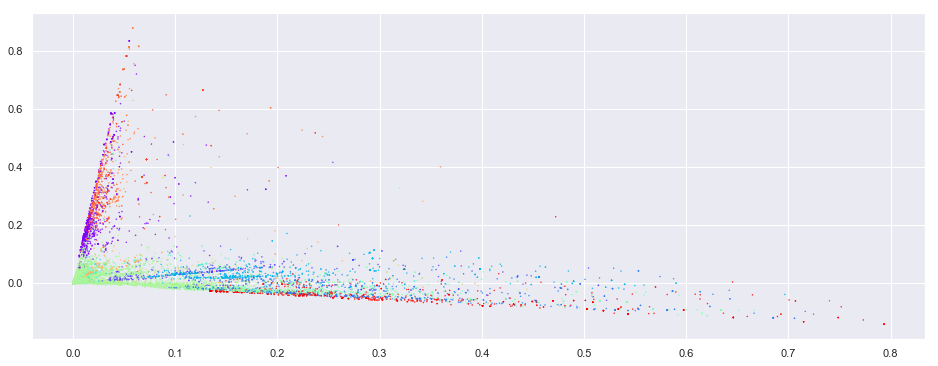

In [37]:
from sklearn.decomposition import TruncatedSVD
tSVD = TruncatedSVD(n_components=2)
tSVD_list = tSVD.fit_transform(X)
plt.figure(figsize=(16, 6))
ax = plt.subplot(111)
ax.scatter(tSVD_list[:,0], tSVD_list[:,1], c=kmeans_labels, cmap='rainbow', s=0.2)

In [38]:
import nltk
#plot top 20 words
def topWords(clusterDf, title):
    corpus = clusterDf["pur"].astype(str)
    modCorpus = " ".join(corpus)
    tok = nltk.tokenize.word_tokenize(modCorpus)
    trigrams = nltk.trigrams(tok)
    freqs = nltk.FreqDist(trigrams)
    freqs.plot(20, title = title, cumulative=False)
    #print(clusterDf["pur"].sample(6))

## Cluster Naming

For this part, we loop through each cluster and identify the top 20 trigrams (groupings of 3 words) You can see these charts at the end of the document. You'll probably observe what appears to be a degree of blended categories, but it is important to remember that these clusters represent patterns in purpose code writing, not human-defined categories.

Every cluster is defined by its most common words. Unfortunately, we have to interpret these two derive cluster names.

Here is how I would name (in English) each of the resulting clusters:
* Cluster 0: Postage and mailers
* Cluster 1: Online advertising (excluding FB)
* Cluster 2: TV ad placement
* Cluster 3: TV advertising (vague/general)
* Cluster 4: Website development
* Cluster 5: List rentals and online advertising
* Cluster 6: Newspaper ads
* Cluster 7: Combined TV and Digital purpose codes
* Cluster 8: Advance pays
* Cluster 9: Canvassing
* Cluster 10: Direct mail
* Cluster 11: Voter contact
* Cluster 12: Media buy

As you might have observed, it seems that the K Means algorithm picks up upon distinctions between vague purpose phrases and similar, but more specific, purpose phrases. These are (usually) seperated into different categories.

# %% Conclusion and Future recommendations

The important news from this report is that our eight categories are actually each composed of several sub-categories.

From this conclusion, I would recommend incorporating K-Means classification as an analysis/validation tool *after* applying the other machine learning methods as a method of both a) discovery and b) validation. An application of the algorithm to each cluster would tell us just how many sub-categories exist in each super-category, and what exactly they are composed of. In a way, this would computationally generate a document that is similar to a codebook. This application would also allow us to state, with mathematical certainty, that our categories are well-defined.

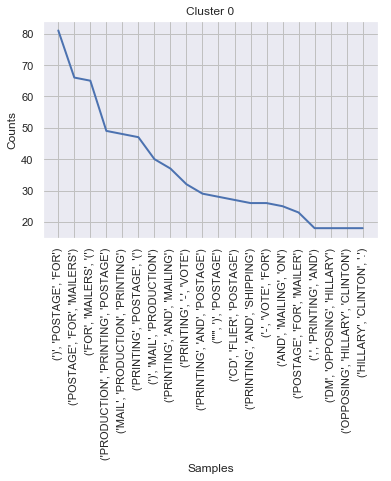

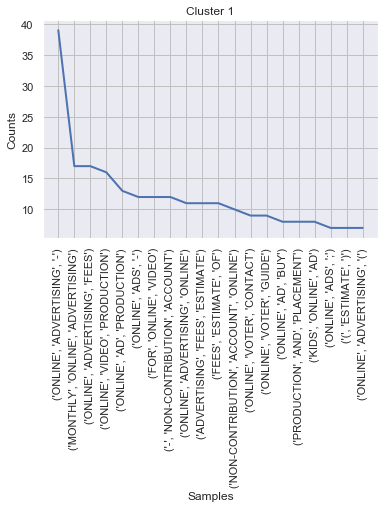

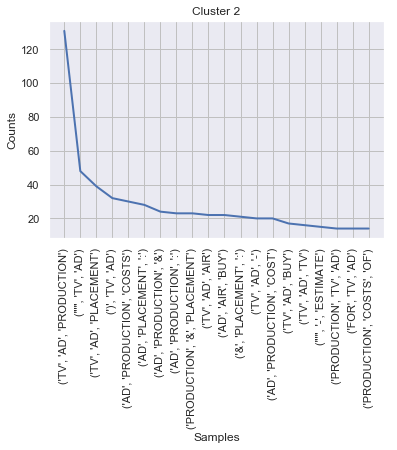

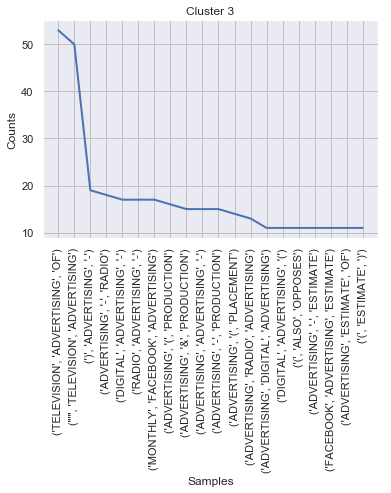

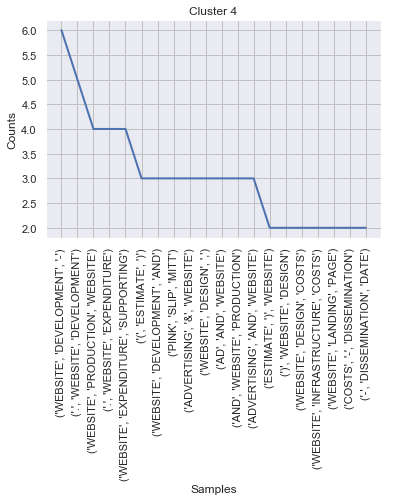

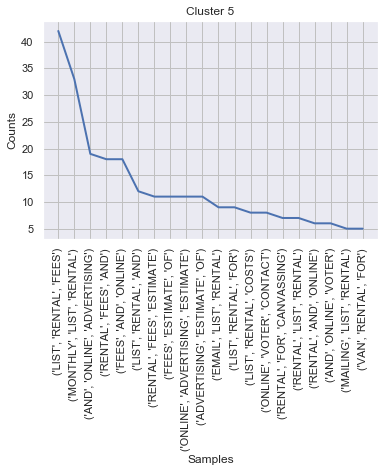

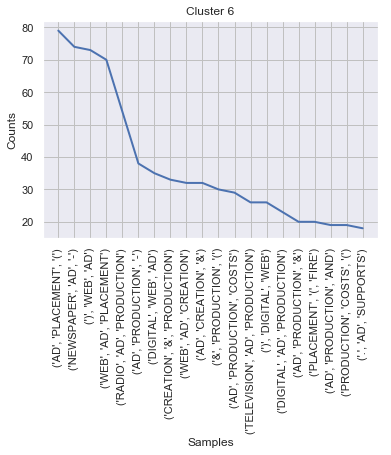

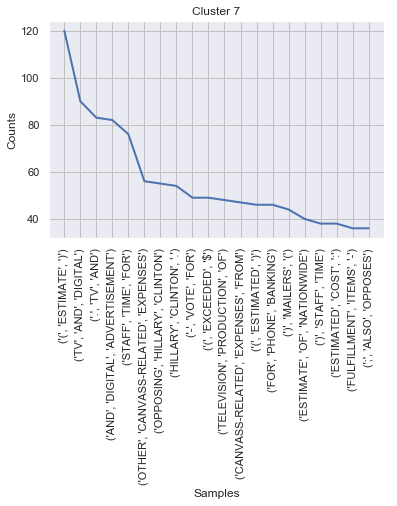

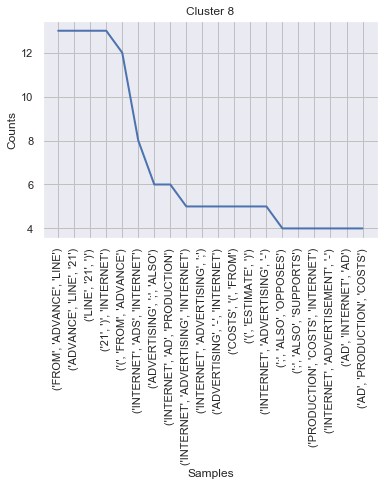

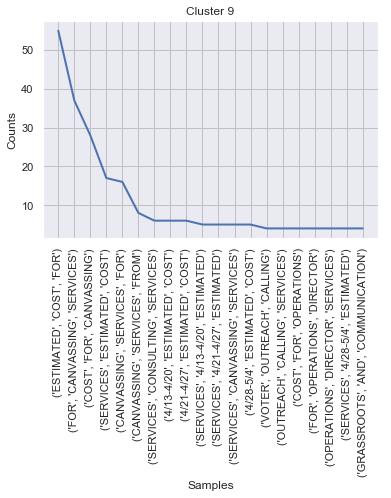

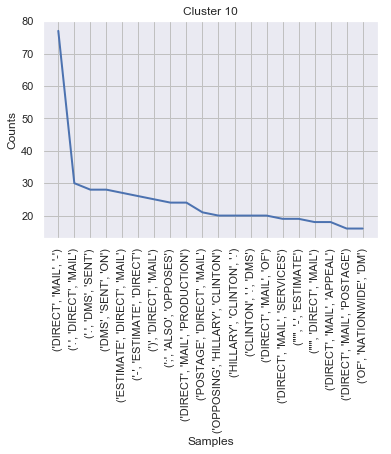

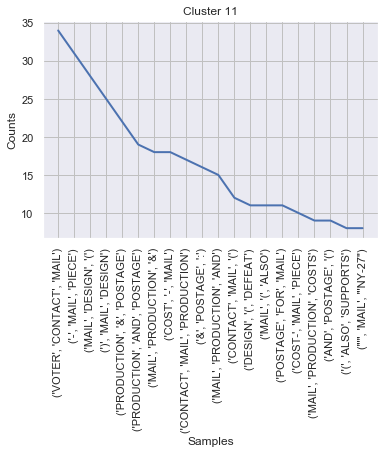

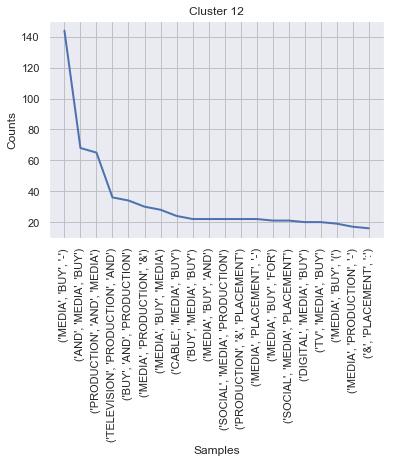

In [39]:
for clusterNum in range(0, k):
    clusterDf = df_kmeansKey[df_kmeansKey["cluster"] == clusterNum]
    topWords(clusterDf, "Cluster " + str(clusterNum))